In [61]:
# main
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import train_test_split


# Time Series Models
import statsmodels.api as sm           # ARIMA / SARIMAX
from prophet import Prophet            # Prophet 

In [2]:
#reading csv as a dataframe
df = pd.read_csv('/Users/KevinBrcic_1/Downloads/generate-tech-challenge/data-tech-challenge/data/data.csv')

### **Data Cleaning**

In [3]:
df.shape

(9999, 15)

In [4]:
df.head()

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
0,Jan-85,Adelaide,Auckland,New Zealand,1513,42.167,0.311,985,18.704,0.924,2498,60.871,1.235,1985,1
1,Jan-85,Adelaide,Bahrain,Bahrain,12,0.000,0.000,5,0.033,0.000,17,0.033,0.000,1985,1
2,Jan-85,Adelaide,Bombay,India,7,0.000,0.000,5,0.000,0.000,12,0.000,0.000,1985,1
3,Jan-85,Adelaide,Frankfurt,Germany,115,0.009,0.000,171,0.000,0.248,286,0.009,0.248,1985,1
4,Jan-85,Adelaide,London,UK,1567,2.800,0.000,1472,10.618,2.487,3039,13.418,2.487,1985,1


In [5]:
df['AustralianPort'].value_counts()

AustralianPort
Sydney            2383
Melbourne         1880
Brisbane          1593
Perth             1293
Adelaide           895
Darwin             675
Cairns             609
Townsville         421
Hobart             109
Port Hedland        87
Norfolk Island      54
Name: count, dtype: int64

In [6]:
df['ForeignPort'].value_counts()

ForeignPort
Auckland      492
Singapore     410
London        407
Frankfurt     383
Bahrain       377
             ... 
Copenhagen      5
Ljubljana       2
Fukuoka         2
Malta           2
Dunedin         1
Name: count, Length: 66, dtype: int64

In [7]:
df['Country'].value_counts()

Country
USA                     1113
New Zealand              945
UK                       732
Indonesia                591
Singapore                410
Germany                  383
Bahrain                  377
Italy                    374
Japan                    366
United Arab Emirates     366
Thailand                 363
India                    343
Greece                   306
Canada                   276
Hong Kong                265
Netherlands              245
Fiji                     227
Yugoslavia               225
Papua New Guinea         201
Malaysia                 190
Oman                     177
Philippines              173
New Caledonia            162
Tahiti                   154
Zimbabwe                 120
Vanuatu                  112
China                    103
Sri Lanka                101
Nauru                     96
Mauritius                 69
South Africa              68
Brunei                    66
Solomon Islands           58
Western Samoa             54
France

In [8]:
df['Year'].value_counts()

Year
1988    2361
1987    2284
1986    2224
1985    1944
1989    1186
Name: count, dtype: int64

In [9]:
df['Month_num'].value_counts()

Month_num
4     924
6     923
5     920
3     919
1     914
2     914
12    762
7     761
10    754
11    752
8     730
9     726
Name: count, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Month                   9999 non-null   object 
 1   AustralianPort          9999 non-null   object 
 2   ForeignPort             9999 non-null   object 
 3   Country                 9999 non-null   object 
 4   Passengers_In           9999 non-null   int64  
 5   Freight_In_(tonnes)     9999 non-null   float64
 6   Mail_In_(tonnes)        9999 non-null   float64
 7   Passengers_Out          9999 non-null   int64  
 8   Freight_Out_(tonnes)    9999 non-null   float64
 9   Mail_Out_(tonnes)       9999 non-null   float64
 10  Passengers_Total        9999 non-null   int64  
 11  Freight_Total_(tonnes)  9999 non-null   float64
 12  Mail_Total_(tonnes)     9999 non-null   float64
 13  Year                    9999 non-null   int64  
 14  Month_num               9999 non-null   

**Observations**
- No nulls in any of the columns, altough numeric columns have 0s
- Date will have to be converted to DateTime object
- Convenient to have a route column combining Australian Port to Foreign Port


In [11]:
df_clean = df.copy()

In [12]:
# date column of type datetime for easier manipulation
df_clean['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_num'].astype(str) + '-' + '01')

In [13]:
# route column to have an identifier for it
df_clean['Route'] = df['AustralianPort'] + '-' + df['ForeignPort']

In [14]:
df_clean.head()

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num,Date,Route
0,Jan-85,Adelaide,Auckland,New Zealand,1513,42.167,0.311,985,18.704,0.924,2498,60.871,1.235,1985,1,1985-01-01,Adelaide-Auckland
1,Jan-85,Adelaide,Bahrain,Bahrain,12,0.000,0.000,5,0.033,0.000,17,0.033,0.000,1985,1,1985-01-01,Adelaide-Bahrain
2,Jan-85,Adelaide,Bombay,India,7,0.000,0.000,5,0.000,0.000,12,0.000,0.000,1985,1,1985-01-01,Adelaide-Bombay
3,Jan-85,Adelaide,Frankfurt,Germany,115,0.009,0.000,171,0.000,0.248,286,0.009,0.248,1985,1,1985-01-01,Adelaide-Frankfurt
4,Jan-85,Adelaide,London,UK,1567,2.800,0.000,1472,10.618,2.487,3039,13.418,2.487,1985,1,1985-01-01,Adelaide-London


In [15]:
# sanity check
print("Unique routes:", df_clean["Route"].nunique())
print("Date range:", df_clean["Date"].min(), "to", df_clean["Date"].max())

Unique routes: 306
Date range: 1985-01-01 00:00:00 to 1989-07-01 00:00:00


In [16]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Month                   9999 non-null   object        
 1   AustralianPort          9999 non-null   object        
 2   ForeignPort             9999 non-null   object        
 3   Country                 9999 non-null   object        
 4   Passengers_In           9999 non-null   int64         
 5   Freight_In_(tonnes)     9999 non-null   float64       
 6   Mail_In_(tonnes)        9999 non-null   float64       
 7   Passengers_Out          9999 non-null   int64         
 8   Freight_Out_(tonnes)    9999 non-null   float64       
 9   Mail_Out_(tonnes)       9999 non-null   float64       
 10  Passengers_Total        9999 non-null   int64         
 11  Freight_Total_(tonnes)  9999 non-null   float64       
 12  Mail_Total_(tonnes)     9999 non-null   float64 

In [17]:
df_clean[df_clean['Route']== 'Hobart-Los Angeles']

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num,Date,Route
9095,Feb-89,Hobart,Los Angeles,USA,2,0.0,0.0,0,0.0,0.0,2,0.0,0.0,1989,2,1989-02-01,Hobart-Los Angeles


### **Exploratory Data Analysis**

In [18]:
# group by route and sum total passengers
route_passengers = df_clean.groupby("Route")["Passengers_Total"].sum().sort_values(ascending=False)

# most trafficked routes (top 10)
print("Most Trafficked Routes by Total Passengers:")
print(route_passengers.head(10))

# least trafficked routes (bottom 10)
print("\nLeast Trafficked Routes by Total Passengers:")
print(route_passengers.tail(10))


Most Trafficked Routes by Total Passengers:
Route
Sydney-Auckland        2961212
Sydney-Singapore       1440018
Sydney-Tokyo           1292116
Sydney-Hong Kong       1151900
Perth-Singapore         952926
Brisbane-Auckland       893246
Sydney-Christchurch     882357
Melbourne-Singapore     865251
Sydney-Los Angeles      862964
Sydney-Honolulu         861814
Name: Passengers_Total, dtype: int64

Least Trafficked Routes by Total Passengers:
Route
Hobart-Los Angeles           2
Hobart-Tokyo                 1
Cairns-Honiara               1
Townsville-San Francisco     1
Darwin-Zagreb                1
Melbourne-Denver             0
Perth-Bandar Seri Begawan    0
Brisbane-Colombo             0
Adelaide-Harare              0
Brisbane-Chicago             0
Name: Passengers_Total, dtype: int64


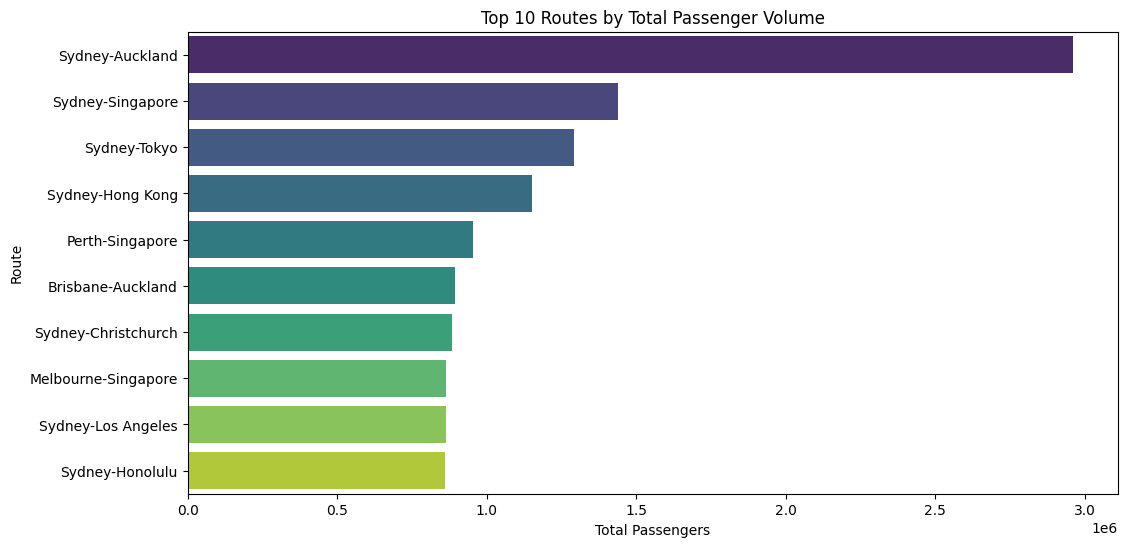

In [19]:
# Top 10 routes bar chart
plt.figure(figsize=(12,6))
sns.barplot(x=route_passengers.head(10).values, y=route_passengers.head(10).index, hue = route_passengers.head(10).index, legend = False, 
            palette="viridis")
plt.title("Top 10 Routes by Total Passenger Volume")
plt.xlabel("Total Passengers")
plt.ylabel("Route")
plt.show()

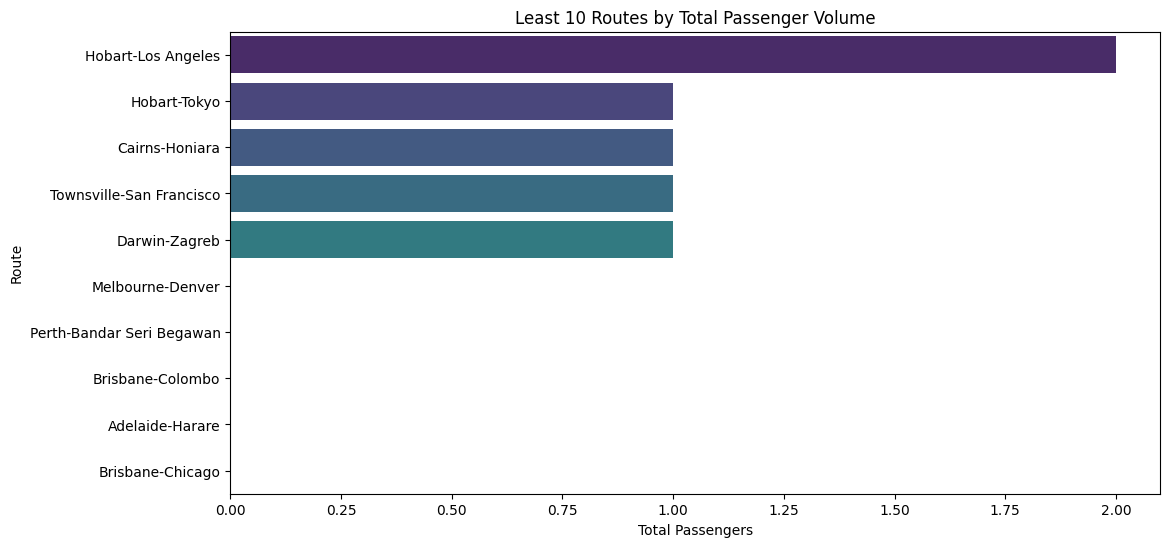

In [20]:
# Least 10 routes bar chart
plt.figure(figsize=(12,6))
sns.barplot(x=route_passengers.tail(10).values, y=route_passengers.tail(10).index, hue = route_passengers.tail(10).index, legend = False, 
            palette="viridis")
plt.title("Least 10 Routes by Total Passenger Volume")
plt.xlabel("Total Passengers")
plt.ylabel("Route")
plt.show()

**Observations – Q1a (Most & Least Trafficked Routes)**

**Most Trafficked Routes**
- The busiest international routes are **Sydney-based connections**, especially:
  - **Sydney–Auckland**, **Sydney–Singapore**, and **Sydney–Tokyo**.  
- These routes carried **millions of passengers** over the dataset, making them critical air corridors.  
- Secondary hubs like **Perth–Singapore** and **Brisbane–Auckland** also appear in the top 10, highlighting their role as important regional links.  
- **Insight**: Sydney is the dominant hub in Australia’s international air travel network.

**Least Trafficked Routes**
- The least trafficked routes are primarily from smaller cities (like Hobart, Townsville, Darwin) to distant or niche destinations such as:
  - Los Angeles, Tokyo, San Francisco, Zagreb.  
- These connections show extremely low passenger totals (thousands across decades).  
- Many of these routes were likely short-lived, experimental, or niche demand connections.

**General Insights**
- Passenger demand is highly concentrated in hub-to-hub routes linking Sydney, Melbourne, Brisbane, and Perth to key Asian, Pacific, and U.S. cities.  
- Smaller city international links are way less viable in terms of passenger volume.  
- **Strategic implication**: AeroConnect should invest heavily in strengthening hub routes while scaling back or avoiding expansion on low-volume, peripheral routes.


In [21]:
# most and least flown routes
flew_route_counts = df_clean['Route'].value_counts()
max_count = flew_route_counts.max()
min_count = flew_route_counts.min()
most_flew_routes = flew_route_counts[flew_route_counts == max_count]
least_flew_routes = flew_route_counts[flew_route_counts == min_count]

In [22]:
print('Most Flown Routes:')
print(most_flew_routes.astype(str))

Most Flown Routes:
Route
Adelaide-Auckland     55
Adelaide-London       55
Adelaide-Singapore    55
Adelaide-Rome         55
Adelaide-Bahrain      55
Adelaide-Frankfurt    55
Name: count, dtype: object


In [23]:
print('Least Flown Routes:')
print(least_flew_routes.astype(str))

Least Flown Routes:
Route
Hobart-Los Angeles          1
Hobart-Singapore            1
Townsville-Manila           1
Hobart-Manila               1
Darwin-Kuala Lumpur         1
Melbourne-Malta             1
Brisbane-Chicago            1
Sydney-Malta                1
Adelaide-Harare             1
Perth-Port Moresby          1
Melbourne-Copenhagen        1
Melbourne-Ljubljana         1
Melbourne-Denver            1
Brisbane-Colombo            1
Darwin-Zagreb               1
Sydney-Copenhagen           1
Brisbane-Zagreb             1
Townsville-Zagreb           1
Perth-Copenhagen            1
Darwin-Copenhagen           1
Townsville-San Francisco    1
Perth-Manila                1
Adelaide-Copenhagen         1
Sydney-Ljubljana            1
Cairns-Larnaca              1
Melbourne-Mauritius         1
Sydney-Dunedin              1
Townsville-Nadi             1
Cairns-Honiara              1
Townsville-Los Angeles      1
Name: count, dtype: object


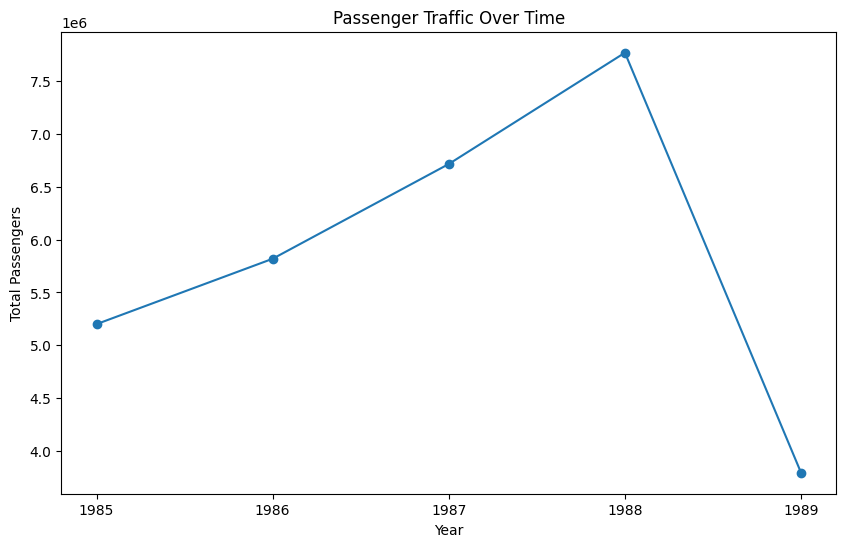

In [24]:
# grup by year and sum total passengers
yearly_passengers = df_clean.groupby('Year')['Passengers_Total'].sum()

# Plot
plt.figure(figsize=(10,6))
plt.plot(yearly_passengers.index, yearly_passengers.values, marker='o')
plt.title('Passenger Traffic Over Time')
plt.xlabel('Year')
plt.ylabel('Total Passengers')
plt.xticks(range(yearly_passengers.index.min(), yearly_passengers.index.max()+1))
plt.show()


**Observations on Passenger Traffic (1985–1989)**

- **1985–1988 Growth**: Passenger traffic shows steady growth from around 5.2M in 1985 to a peak of  around 7.8M in 1988.  
- **Peak in 1988**: 1988 marks the highest recorded passenger traffic in this period.  
- **Sharp Decline in 1989**: Passenger numbers dropped dramatically to ~3.8M in 1989, breaking the upward trend.  
- **Overall Trend**: Despite the 1989 dip, the long-term trend (1985–1988) suggests increasing demand and traffic growth.  


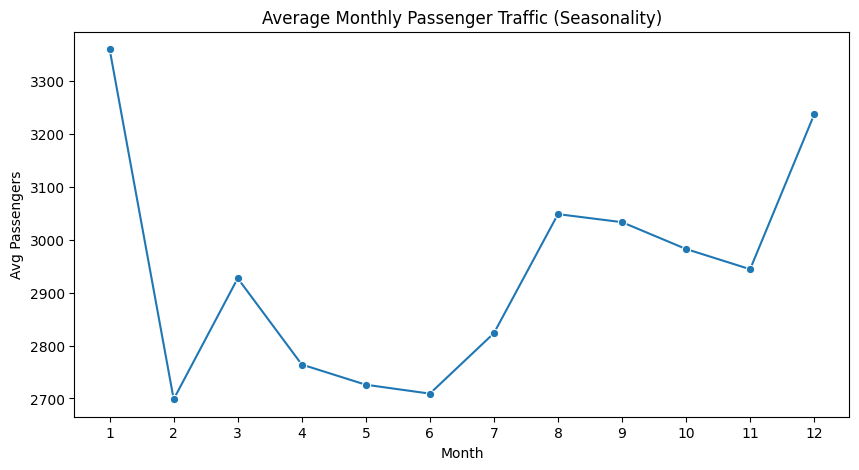

In [25]:
# average passengers by month (1=Jan, 12=Dec)
monthly_trends = df_clean.groupby("Month_num")["Passengers_Total"].mean()
plt.figure(figsize=(10,5))
sns.lineplot(x=monthly_trends.index, y=monthly_trends.values, marker="o")
plt.title("Average Monthly Passenger Traffic (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Avg Passengers")
plt.xticks(range(1,13))
plt.show()


**Observations on Monthly Passenger Seasonality**

- **Peak in January**: Highest passenger traffic occurs in January (around 3,350 avg passengers).  
- **Low in February**: Sharp decline in February to the lowest point (aprox 2,700).  
- **Spring Stability**: March–June remain relatively steady with minor fluctuations.  
- **Summer Increase**: Gradual rise from July, peaking again in August (aprox 3,050).  
- **Year-End Recovery**: Traffic picks up strongly in December (aprox 3,250), suggesting holiday travel demand.  
- **Overall Pattern**: Clear seasonal cycles with peaks in January, August, and December.


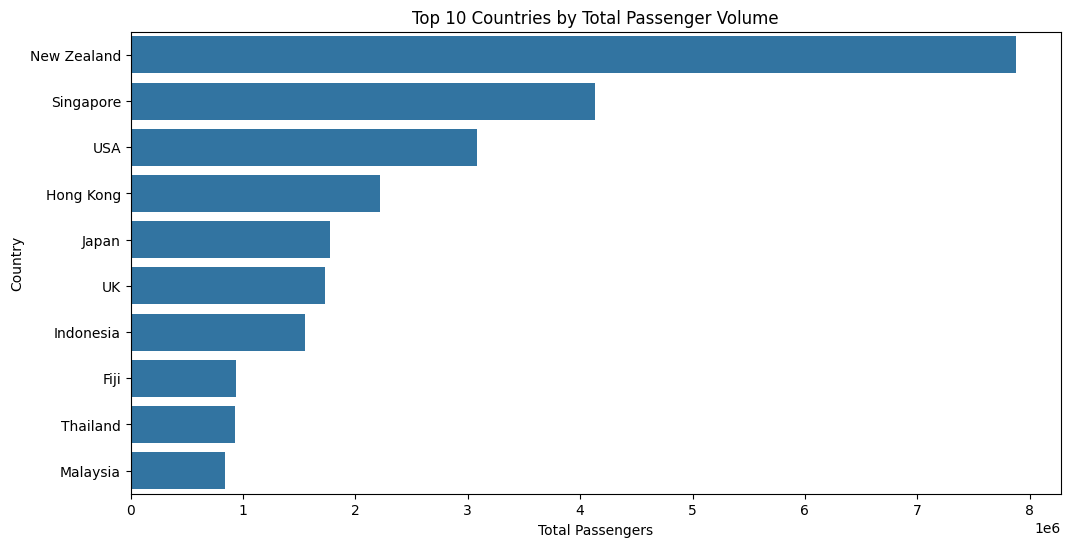

In [26]:
# top 10 countries by passenger volume
country_passengers = df_clean.groupby("Country")["Passengers_Total"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=country_passengers.values, y=country_passengers.index)
plt.title("Top 10 Countries by Total Passenger Volume")
plt.xlabel("Total Passengers")
plt.ylabel("Country")
plt.show()

**Observations on Top 10 Countries by Passenger Volume**

- New Zealand dominates with the highest passenger volume (~8M), far ahead of others.  
- Singapore and the USA follow as the 2nd and 3rd most significant markets.  
- Hong Kong, Japan, and the UK form the mid-tier group with strong traffic.  
- Indonesia, Fiji, Thailand, and Malaysia contribute smaller but still notable volumes.  
- Clear **regional concentration**: most top routes are within the Asia-Pacific region, highlighting strong regional connectivity.  


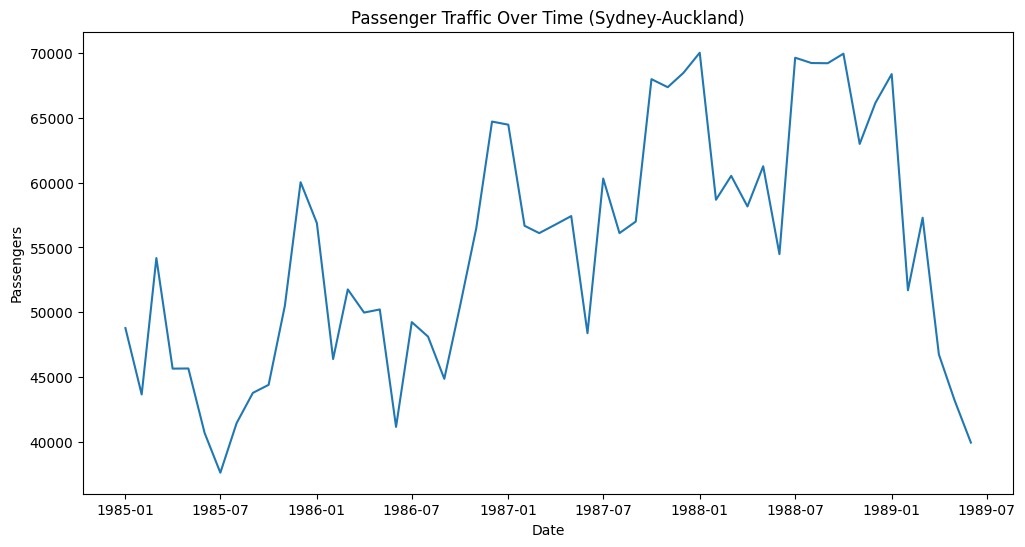

In [27]:
# Sydney - Auckland over time
route = "Sydney-Auckland"
route_trend = df_clean[df_clean["Route"] == route].groupby("Date")["Passengers_Total"].sum()

plt.figure(figsize=(12,6))
sns.lineplot(x=route_trend.index, y=route_trend.values)
plt.title(f"Passenger Traffic Over Time ({route})")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()


**Observations on Sydney–Auckland Passenger Traffic**
- Passenger traffic shows strong seasonal fluctuations, with peaks and troughs recurring each year.  
- Overall, there is a growth trend from 1985 to 1988, with volumes climbing from aprox 40k to aprox 70k passengers.  
- **1988 marks the peak**, with passenger traffic reaching its highest sustained levels.  
- A **sharp decline begins in 1989**, suggesting possible external disruptions like policy, economic, or operational changes.  

In [28]:
#exporting cleaned data as csv
df_clean.to_csv('/Users/KevinBrcic_1/Downloads/generate-tech-challenge/data-tech-challenge/data/cleaned-data.csv', index=False)

### **Building Model**

**Feature Engineering**

To create the model we have to add a few columns. We are trying to predict passenger traffic for the next 6-12 months for routes, therefore we need to have lag columns as the traffic from the previous months influences the next one. Furthermore, we will need rolling features to reduce the noise of the dataset and be able to caputre the overall trend. This is done over each specific routes. To do this we also have to sort the same routes by date.

In [29]:
model_data = df_clean.copy()

In [30]:
model_data = model_data.sort_values(['Route', 'Date'])

In [31]:
# creating the lags inside each group, as each group is independe of the other
model_data['Lag1'] = model_data.groupby('Route')['Passengers_Total'].shift(1)
model_data["Lag3"] = model_data.groupby("Route")["Passengers_Total"].shift(3)
model_data["Lag12"] = model_data.groupby("Route")["Passengers_Total"].shift(12)

In [32]:
# creating rolling features again for each group
model_data["Rolling3"] = model_data.groupby("Route")["Passengers_Total"].rolling(3).mean().reset_index(0, drop=True)
model_data["Rolling12"] = model_data.groupby("Route")["Passengers_Total"].rolling(12).mean().reset_index(0, drop=True)

Lags for 1, 3 and 12 months were chose because: 
-Lag 1: captures the immediate short-term dependence, and passenger numbers this month are usually highly correlated with last month.
-Lag 3: captures quarterly patterns. In airlines, demand often shifts every season.
-Lag 12: Captures yearly seasonality. Passenger volumes tend to repeat yearly cycles.

Rolling features for 3 and 12 months were chose because:
-Rolling 3: captures quarterly patterns, so short term trends (same as lag3)
-Rolling 12: captures yearly patterns, so long terms trends (same as lag12)

In [33]:
model_data

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),...,Mail_Total_(tonnes),Year,Month_num,Date,Route,Lag1,Lag3,Lag12,Rolling3,Rolling12
476,Apr-85,Adelaide,Abu Dhabi,United Arab Emirates,3,0.000,0.0,0,0.000,0.0,...,0.0,1985,4,1985-04-01,Adelaide-Abu Dhabi,NaN,NaN,NaN,NaN,NaN
641,May-85,Adelaide,Abu Dhabi,United Arab Emirates,14,0.000,0.0,0,0.000,0.0,...,0.0,1985,5,1985-05-01,Adelaide-Abu Dhabi,3.0,NaN,NaN,NaN,NaN
796,Jun-85,Adelaide,Abu Dhabi,United Arab Emirates,2,0.000,0.0,0,0.000,0.0,...,0.0,1985,6,1985-06-01,Adelaide-Abu Dhabi,14.0,NaN,NaN,6.333333,NaN
957,Jul-85,Adelaide,Abu Dhabi,United Arab Emirates,8,0.000,0.0,0,0.000,0.0,...,0.0,1985,7,1985-07-01,Adelaide-Abu Dhabi,2.0,3.0,NaN,8.000000,NaN
1117,Aug-85,Adelaide,Abu Dhabi,United Arab Emirates,4,0.000,0.0,0,0.000,0.0,...,0.0,1985,8,1985-08-01,Adelaide-Abu Dhabi,8.0,14.0,NaN,4.666667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9408,Mar-89,Townsville,Singapore,Singapore,320,3.840,0.0,413,1.558,0.0,...,0.0,1989,3,1989-03-01,Townsville-Singapore,550.0,797.0,596.0,678.000000,608.666667
9598,Apr-89,Townsville,Singapore,Singapore,269,2.027,0.0,334,0.261,0.0,...,0.0,1989,4,1989-04-01,Townsville-Singapore,733.0,751.0,557.0,628.666667,612.500000
9787,May-89,Townsville,Singapore,Singapore,194,2.533,0.0,302,0.103,0.0,...,0.0,1989,5,1989-05-01,Townsville-Singapore,603.0,550.0,485.0,610.666667,613.416667
9978,Jun-89,Townsville,Singapore,Singapore,286,3.832,0.0,321,1.183,0.0,...,0.0,1989,6,1989-06-01,Townsville-Singapore,496.0,733.0,561.0,568.666667,617.250000


We have to drop the rows that have null values because we cant train a model on null values 

In [34]:
df_model_nonull = model_data.dropna()

In [35]:
df_model_nonull.shape[0]

7080

In [36]:
df_model_nonull.columns

Index(['Month', 'AustralianPort', 'ForeignPort', 'Country', 'Passengers_In',
       'Freight_In_(tonnes)', 'Mail_In_(tonnes)', 'Passengers_Out',
       'Freight_Out_(tonnes)', 'Mail_Out_(tonnes)', 'Passengers_Total',
       'Freight_Total_(tonnes)', 'Mail_Total_(tonnes)', 'Year', 'Month_num',
       'Date', 'Route', 'Lag1', 'Lag3', 'Lag12', 'Rolling3', 'Rolling12'],
      dtype='object')

We don't need the following columns for the prediction so we can drop them:
- AustralianPort, ForeignPort, Country are redundant as I have route.
- Month (we already have month num)
- Passengers_In, Passengers_Out these sum into Passengers_Total
- Freight_In_(tonnes), Freight_Out_(tonnes), Mail_In_(tonnes), Mail_Out_(tonnes), Freight_Total_(tonnes), Mail_Total_(tonnes)
- Date (model can't work with datetime objs, instead we use year and month num)

In [37]:
df_model_f = df_model_nonull[['Passengers_Total', 'Year', 'Month_num', 'Route', 'Lag1', 'Lag3', 'Lag12', 'Rolling3', 'Rolling12']]

**Random Forest**

In [53]:
# Filter dataset for this route
df_with_date = df_model_nonull[['Date', 'Route']]
df_with_date = df_with_date[df_with_date['Route'] == 'Sydney-Auckland'].copy()
route_df = df_model_f[df_model_f['Route'] == 'Sydney-Auckland'].copy()
route_df = route_df.sort_values(['Year', 'Month_num'])
    
# Define features and target
X = route_df[['Year', 'Month_num', 'Lag1', 'Lag3', 'Lag12', 'Rolling3', 'Rolling12']]
y = route_df['Passengers_Total']

# split into train and test
split_idx = int(len(route_df) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Train model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

results = {"MAE": mae, "RMSE": rmse, "R2": r2}
print(f"Test Results for {route}: {results}")


Test Results for Sydney-Auckland: {'MAE': 6523.126153846153, 'RMSE': np.float64(7496.12915899933), 'R2': 0.4908851187327653}


**Hyperparameter tuning**

GridSearch used to exhaust most of the options

In [39]:
# Example param grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5,6,7],
    'min_samples_split': [7,8,9,10],
    'min_samples_leaf': [5,6,7]
}
    
tscv = TimeSeriesSplit(n_splits=5)
    
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
    
grid_search.fit(X_train, y_train)
    
print("Best parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)


Best parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 1000}
Best MAE: 6138.668051853466


In [40]:
best_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=5,
    min_samples_leaf=5,
    min_samples_split=7,
    random_state=42
)
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print("Evaluation on Test Set:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE : {mape:.2f}%")

Evaluation on Test Set:
MAE: 6263.32
RMSE: 7116.97
R²: 0.5411
MAPE : 11.87%


Model has clearly improved, the MAE and RMSE have reduced, and the R squared increased which is good

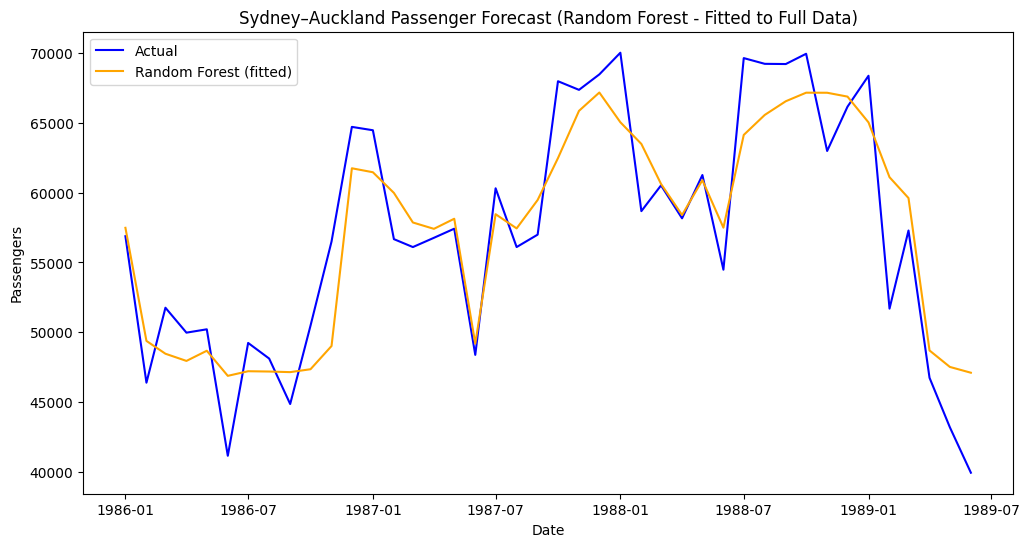

In [54]:
best_model.fit(X, y)
# Predict for entire dataset
y_all_pred = best_model.predict(X)

plt.figure(figsize=(12,6))
plt.plot(df_with_date['Date'], y, label="Actual", color="blue")
plt.plot(df_with_date['Date'], y_all_pred, label="Random Forest (fitted)", color="orange")
plt.legend()
plt.title("Sydney–Auckland Passenger Forecast (Random Forest - Fitted to Full Data)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()

In [57]:
last_date = df_with_date['Date'].max()
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')

future_preds = []
df_forecast = route_df.copy()

for date in future_dates:
    year = date.year
    month_num = date.month
    
    # Build feature row using past values
    lag1 = df_forecast['Passengers_Total'].iloc[-1]
    lag3 = df_forecast['Passengers_Total'].iloc[-3] if len(df_forecast) >= 3 else lag1
    lag12 = df_forecast['Passengers_Total'].iloc[-12] if len(df_forecast) >= 12 else lag1
    
    rolling3 = df_forecast['Passengers_Total'].iloc[-3:].mean()
    rolling12 = df_forecast['Passengers_Total'].iloc[-12:].mean() if len(df_forecast) >= 12 else rolling3
    
    X_future = pd.DataFrame([{
        'Year': year,
        'Month_num': month_num,
        'Lag1': lag1,
        'Lag3': lag3,
        'Lag12': lag12,
        'Rolling3': rolling3,
        'Rolling12': rolling12
    }])
    
    # Predict with trained RF
    y_future = best_model.predict(X_future)[0]
    
    # Save prediction
    future_preds.append({'Date': date, 'Passengers_Total': y_future})
    
    # Append prediction back so it can be used as lag for next step
    df_forecast = pd.concat([df_forecast, pd.DataFrame([{
        'Date': date,
        'Passengers_Total': y_future
    }])], ignore_index=True)

future_df = pd.DataFrame(future_preds)



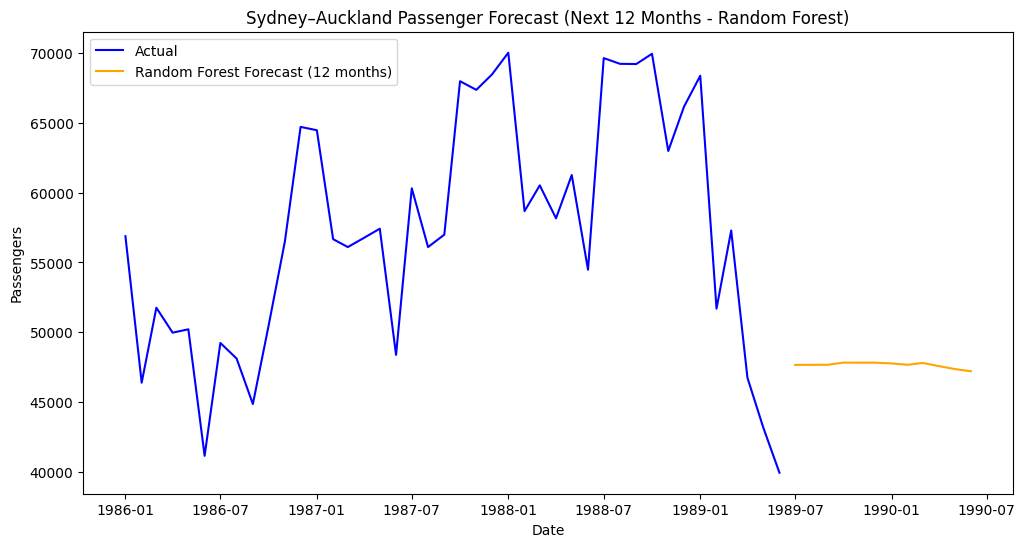

In [59]:
plt.figure(figsize=(12,6))
plt.plot(df_with_date['Date'], route_df['Passengers_Total'], label="Actual", color="blue")
plt.plot(future_df['Date'], future_df['Passengers_Total'], label="Random Forest Forecast (12 months)", color="orange")
plt.legend()
plt.title("Sydney–Auckland Passenger Forecast (Next 12 Months - Random Forest)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()


Add transformation so model understands better seasons

In [62]:
X['Month_sin'] = np.sin(2 * np.pi * df_model_nonull['Month_num'] / 12)
X['Month_cos'] = np.cos(2 * np.pi * df_model_nonull['Month_num'] / 12)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

best_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=5,
    min_samples_leaf=5,
    min_samples_split=7,
    random_state=42
)
best_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=7,
                      n_estimators=1000, random_state=42)

In [64]:

last_date = df_with_date['Date'].max()
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')

future_preds = []
df_forecast = route_df.copy()

for date in future_dates:
    year = date.year
    month_num = date.month
    
    # Cyclical features
    month_sin = np.sin(2 * np.pi * month_num / 12)
    month_cos = np.cos(2 * np.pi * month_num / 12)
    
    lag1 = df_forecast['Passengers_Total'].iloc[-1]
    lag3 = df_forecast['Passengers_Total'].iloc[-3] if len(df_forecast) >= 3 else lag1
    lag12 = df_forecast['Passengers_Total'].iloc[-12] if len(df_forecast) >= 12 else lag1
    
    rolling3 = df_forecast['Passengers_Total'].iloc[-3:].mean()
    rolling12 = df_forecast['Passengers_Total'].iloc[-12:].mean() if len(df_forecast) >= 12 else rolling3
    
    X_future = pd.DataFrame([{
        'Year': year,
        'Month_num': month_num,          
        'Lag1': lag1,
        'Lag3': lag3,
        'Lag12': lag12,
        'Rolling3': rolling3,
        'Rolling12': rolling12,
        'Month_sin': month_sin,
        'Month_cos': month_cos
    }])
    
    # Predict with trained RF
    y_future = best_model.predict(X_future)[0]
    
    # Save prediction
    future_preds.append({'Date': date, 'Passengers_Total': y_future})
    
    # Append prediction back so it can be used as lag for next step
    df_forecast = pd.concat([df_forecast, pd.DataFrame([{
        'Date': date,
        'Passengers_Total': y_future
    }])], ignore_index=True)

future_df = pd.DataFrame(future_preds)


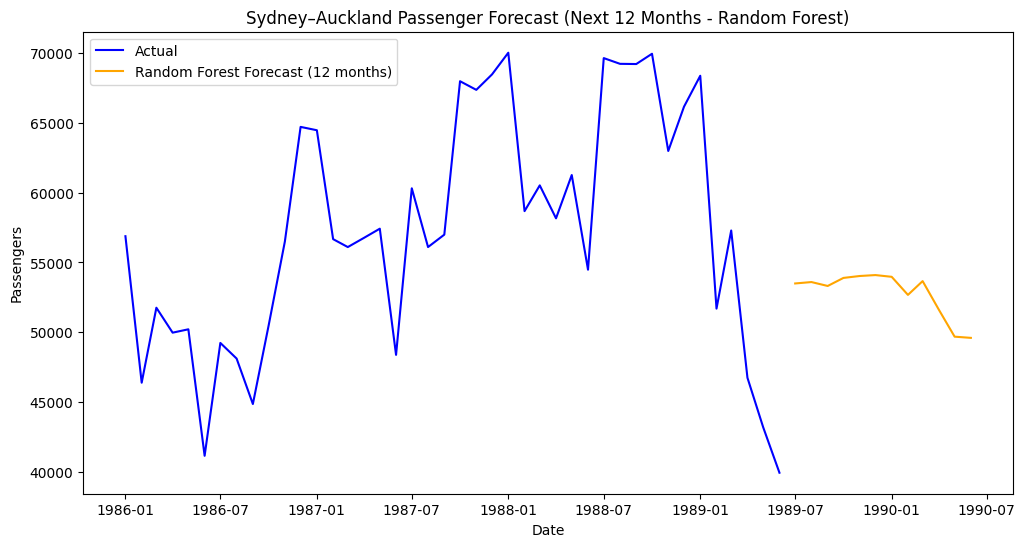

In [65]:
plt.figure(figsize=(12,6))
plt.plot(df_with_date['Date'], route_df['Passengers_Total'], label="Actual", color="blue")
plt.plot(future_df['Date'], future_df['Passengers_Total'], label="Random Forest Forecast (12 months)", color="orange")
plt.legend()
plt.title("Sydney–Auckland Passenger Forecast (Next 12 Months - Random Forest)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()


**Prophet**

we are going to try Prophet model and check if it has a better performance

In [44]:

# Prep data
# Prophet expects columns "ds" (date) and "y" (target)
df_prophet = pd.DataFrame({
    "ds": df_model_nonull[df_model_nonull['Route'] == 'Sydney-Auckland']["Date"],      
    "y": df_model_nonull[df_model_nonull['Route'] == 'Sydney-Auckland']["Passengers_Total"]})    

# Train/Test Split 
train = df_prophet.iloc[:-12]   # all but last 12
test = df_prophet.iloc[-12:]    # last 12 months

#Initialize Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,   
    daily_seasonality=False,
    seasonality_mode="additive"
)


# 4. Fit on train 
model.fit(train)

# Create future dates up to test period
future = model.make_future_dataframe(periods=len(test), freq="MS")  # month start
forecast = model.predict(future)

clean_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

# Merge with actuals (train + test)
df_actuals = df_prophet[['ds', 'y']]  # original actual data
clean_forecast = pd.merge(clean_forecast, df_actuals, on="ds", how="left")

clean_forecast.tail(15) 


14:04:46 - cmdstanpy - INFO - Chain [1] start processing
14:04:46 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y
27,1988-04-01,58165.050637,56928.483415,59383.704541,58160
28,1988-05-01,61165.582259,59920.718943,62371.265002,61259
29,1988-06-01,54467.221307,53120.338515,55698.123688,54483
30,1988-07-01,57960.006499,56781.989295,59366.343590,69629
31,1988-08-01,65848.253509,64575.574063,67018.648350,69219
32,1988-09-01,56649.219837,55385.528073,57977.272036,69204
33,1988-10-01,49782.450711,48460.163094,51145.957211,69939
34,1988-11-01,64234.174264,62725.130769,65608.840275,62981
35,1988-12-01,81647.820769,80171.652858,83056.260228,66149
36,1989-01-01,69535.694871,67895.762829,71155.633147,68365


In [45]:
# Evaluate only on test period 
# Filter forecast for the test range
test_forecast = clean_forecast[clean_forecast['ds'].isin(test['ds'])].copy()

test_forecast = test_forecast.dropna(subset=['y'])

# Extract actuals and predictions
y_true = test_forecast['y']
y_pred = test_forecast['yhat']

#  metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

MAE  : 9869.50
RMSE : 11636.21
MAPE : 17.78%


Random Forest gave a better overall performance on the test data but it isnt very good at identifying seasonality and Prophet is for the Sydney-Auckland flight:
- We got a MAPE of around 11.9% for the random forest Model which is very good, almost excellent, while on the Prophet model, a MAPE of 17.8% which is considered decent for time series forecasting models.

So we will stick with Prophet

14:05:01 - cmdstanpy - INFO - Chain [1] start processing
14:05:01 - cmdstanpy - INFO - Chain [1] done processing


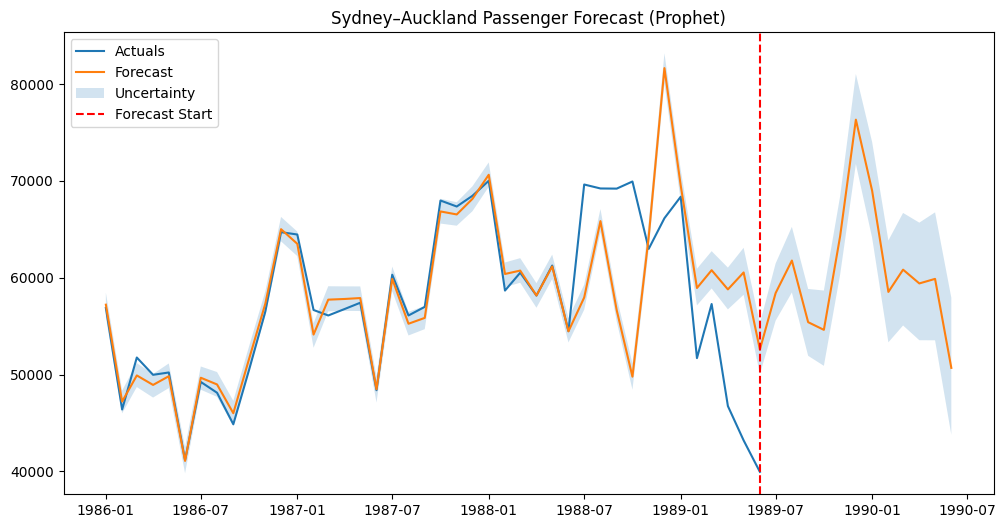

           ds          yhat    yhat_lower    yhat_upper   y
42 1989-07-01  58418.327109  55564.732819  61472.809187 NaN
43 1989-08-01  61775.124781  58479.025128  65256.784079 NaN
44 1989-09-01  55411.244145  51937.466313  58842.182273 NaN
45 1989-10-01  54618.513544  50903.515108  58678.270428 NaN
46 1989-11-01  64291.274915  60329.819011  68417.027464 NaN
47 1989-12-01  76326.680987  71742.260091  81043.372547 NaN
48 1990-01-01  68986.486959  64131.805036  74017.239689 NaN
49 1990-02-01  58536.472469  53329.824418  63844.676044 NaN
50 1990-03-01  60834.364812  55070.922436  66693.393685 NaN
51 1990-04-01  59412.069473  53546.996612  65688.637557 NaN
52 1990-05-01  59882.221470  53538.126504  66752.211599 NaN
53 1990-06-01  50691.381522  43783.298985  57936.897984 NaN


In [46]:
# Prep data
df_prophet = pd.DataFrame({
    "ds": df_model_nonull[df_model_nonull['Route'] == 'Sydney-Auckland']["Date"],      
    "y": df_model_nonull[df_model_nonull['Route'] == 'Sydney-Auckland']["Passengers_Total"]     
})

# Train/Test Split (last 12 months as test)
train = df_prophet.iloc[:-12]
test = df_prophet.iloc[-12:]

# Initialize Prophet
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="additive"
)

# Fit model
model.fit(train)

# Forecast (next 12 months beyond last available date)
future = model.make_future_dataframe(periods=24, freq="MS")  
forecast = model.predict(future)

# Clean forecast
clean_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

# Merge with actuals for plotting
df_actuals = df_prophet[['ds', 'y']]
clean_forecast = pd.merge(clean_forecast, df_actuals, on="ds", how="left")

# Plot historical + forecast
plt.figure(figsize=(12,6))
plt.plot(df_prophet['ds'], df_prophet['y'], label="Actuals")
plt.plot(clean_forecast['ds'], clean_forecast['yhat'], label="Forecast")
plt.fill_between(clean_forecast['ds'],
                 clean_forecast['yhat_lower'],
                 clean_forecast['yhat_upper'],
                 alpha=0.2, label="Uncertainty")
plt.axvline(df_prophet['ds'].iloc[-1], color="red", linestyle="--", label="Forecast Start")
plt.legend()
plt.title("Sydney–Auckland Passenger Forecast (Prophet)")
plt.show()

# 8. Show last 12 predicted months
future_preds = clean_forecast.tail(12)
print(future_preds)
